In [1]:
import numpy as np
import pygame
import time
from pettingzoo.utils import agent_selector
from pettingzoo.utils.env import AECEnv
from gym import spaces
from pettingzoo.utils import wrappers

pygame 2.6.0 (SDL 2.28.4, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class MazeXEnv(AECEnv):
    metadata = {'render_modes':['human','ansi']}
    def __init__(self):
        super().__init__()
        self.maze = np.array([
            [0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1],
            [1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,1],
            [0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1],
            [0,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1],
            [0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1],
            [0,1,0,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1],
            [0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1],
            [1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0,1],
            [0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0,1,0,1],
            [0,1,1,1,0,1,1,1,0,0,0,1,0,0,0,1,0,1,1,1],
            [0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1],
            [0,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1],
            [0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1],
            [0,1,0,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1],
            [0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        ])
        self._cumulative_rewards = {'robber': 0, 'cop': 0}
        self.start = (0, 0)
        self.goal = (14,19)
        self.checkpoints = [(14, 6), (10, 9), (13, 10), (10, 2)]
        self.state = self.start
        self.cop_state = (14, 0)
       
        self.agents = ['robber', 'cop']
        self.agent_order = self.agents
        self._agent_selector = agent_selector(self.agent_order)
        self.agent_selection = self._agent_selector.next()
       
        self.observation_spaces = {agent: spaces.Box(low=0, high=max(self.maze.shape)-1, shape=(2,), dtype=np.int32) for agent in self.agents}
        self.action_spaces = {agent: spaces.Discrete(4) for agent in self.agents}
       
        self.rewards = {agent: 0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}

        self.render_mode = 'human'  # Added render_mode attribute
       
        # Pygame setup
        self.screen_width = 800
        self.screen_height = 600
        self.screen_size = (self.screen_width, self.screen_height)
        self.cell_size = min(self.screen_width // self.maze.shape[1], self.screen_height // self.maze.shape[0])
        pygame.init()
        self.screen = pygame.display.set_mode(self.screen_size)
        pygame.display.set_caption('MazeX')

    def observe(self, agent):
        if agent == 'robber':
            return np.array(self.state)
        elif agent == 'cop':
            return np.array(self.cop_state)

    def reset(self, seed=None, options=None):  # Modified reset to accept seed and options
        self.state = self.start
        self.cop_state = (14, 0)
        self.rewards = {agent: 0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.agent_selection = self._agent_selector.reset()
        self._cumulative_rewards = {'robber': 0, 'cop': 0}
   
    def step(self, action):
        agent = self.agent_selection
       
        if agent == 'robber':
            current_row, current_col = self.state
            next_state = list(self.state)
           
            if action == 0:  # Move right
                if current_col + 1 < self.maze.shape[1] and self.maze[current_row, current_col + 1] == 0:
                    next_state[1] += 1
            elif action == 1:  # Move down
                if current_row + 1 < self.maze.shape[0] and self.maze[current_row + 1, current_col] == 0:
                    next_state[0] += 1
            elif action == 2:  # Move up
                if current_row - 1 >= 0 and self.maze[current_row - 1, current_col] == 0:
                    next_state[0] -= 1
            elif action == 3:  # Move left
                if current_col - 1 >= 0 and self.maze[current_row, current_col - 1] == 0:
                    next_state[1] -= 1
           
            self.rewards[agent] = -1  # Each step costs -1
            if next_state != list(self.state):
                self.state = tuple(next_state)
                if self.state in self.checkpoints:
                    self.rewards[agent] += 30  # Checkpoint reached
                if self.state == self.goal:
                    self.rewards[agent] += 100  # Goal reached
                    self.dones = {agent: True for agent in self.agents}
            else:
                self.dones[agent] = False

        elif agent == 'cop':
            cop_action = self.cop_move()
            self.cop_step(cop_action)
            self.rewards[agent] = -1  # Each step costs -1
       
        # Check if cop catches the robber
        if self.cop_state == self.state:
            self.dones = {agent: True for agent in self.agents}
            self.rewards['robber'] -= 100  # Negative reward if cop catches the robber
       
        self.agent_selection = self._agent_selector.next()
        self._accumulate_rewards()

    def cop_move(self):
        cop_row, cop_col = self.cop_state
        agent_row, agent_col = self.state
       
        if cop_row < agent_row and self.maze[cop_row + 1, cop_col] == 0:
            return 1  # Move down
        elif cop_row > agent_row and self.maze[cop_row - 1, cop_col] == 0:
            return 2  # Move up
        elif cop_col < agent_col and self.maze[cop_row, cop_col + 1] == 0:
            return 0  # Move right
        elif cop_col > agent_col and self.maze[cop_row, cop_col - 1] == 0:
            return 3  # Move left
        return np.random.choice([0, 1, 2, 3])  # Random move if blocked
   
    def cop_step(self, action):
        cop_row, cop_col = self.cop_state
        next_cop_state = list(self.cop_state)
       
        if action == 0: # Move right
            if cop_col + 1 < self.maze.shape[1] and self.maze[cop_row, cop_col + 1] == 0:
                next_cop_state[1] += 1
        elif action == 1:  # Move down
            if cop_row + 1 < self.maze.shape[0] and self.maze[cop_row + 1, cop_col] == 0:
                next_cop_state[0] += 1
        elif action == 2:  # Move up
            if cop_row - 1 >= 0 and self.maze[cop_row - 1, cop_col] == 0:
                next_cop_state[0] -= 1
        elif action == 3:  # Move left
            if cop_col - 1 >= 0 and self.maze[cop_row, cop_col - 1] == 0:
                next_cop_state[1] -= 1
       
        self.cop_state = tuple(next_cop_state)

    def render(self, mode='human'):
        self.screen.fill((255, 255, 255)) # White background

        # Draw the maze
        for row in range(self.maze.shape[0]):
            for col in range(self.maze.shape[1]):
                color = (255, 255, 255) # white color for paths
                if self.maze[row, col] == 1:
                    color = (0, 0, 0) # black color for Walls
                pygame.draw.rect(self.screen, color,
                                 pygame.Rect(col * self.cell_size, row * self.cell_size, self.cell_size, self.cell_size))

        # Draw the start position as green color
        pygame.draw.rect(self.screen, (0, 255, 0),
                         pygame.Rect(self.start[1] * self.cell_size, self.start[0] * self.cell_size, self.cell_size, self.cell_size))

        # Draw the goal position as red color
        pygame.draw.rect(self.screen, (255, 0, 0),
                         pygame.Rect(self.goal[1] * self.cell_size, self.goal[0] * self.cell_size, self.cell_size, self.cell_size))

        # Draw checkpoints as blue color
        for cp in self.checkpoints:
            pygame.draw.rect(self.screen, (0, 0, 255),
                             pygame.Rect(cp[1] * self.cell_size, cp[0] * self.cell_size, self.cell_size, self.cell_size))

        # Draw the robber as a yellow colored square
        pygame.draw.rect(self.screen, (255, 255, 0),
                         pygame.Rect(self.state[1] * self.cell_size, self.state[0] * self.cell_size, self.cell_size, self.cell_size))

        # Draw the cop as an orange colored square
        pygame.draw.rect(self.screen, (255, 165, 0),
                         pygame.Rect(self.cop_state[1] * self.cell_size, self.cop_state[0] * self.cell_size, self.cell_size, self.cell_size))

        pygame.display.flip()
        time.sleep(0.1)

    def close(self):
        pygame.quit()

    def check_event(self):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()
                exit()

# Wrapping the environment
def env():
    env = MazeXEnv()
    env = wrappers.CaptureStdoutWrapper(env)
    return env



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the neural networks for PPO with separate actor and critic networks
class ActorNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_dim)
       
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.softmax(self.fc4(x), dim=-1)
        return x
        
class CriticNetwork(nn.Module):
    def __init__(self, input_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
       
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

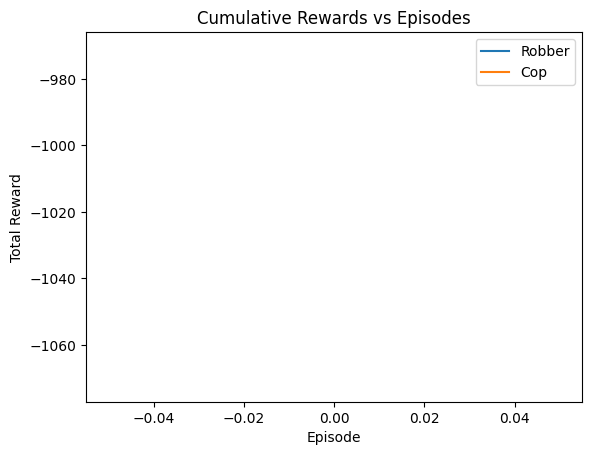

C:\Users\dell\AppData\Local\Temp\ipykernel_21024\1810912911.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:277.)
  states = torch.FloatTensor(self.states)


Episode 0 - Total Reward Robber: -1072, Total Reward Cop: -971


<Figure size 640x480 with 0 Axes>

Episode 1 - Total Reward Robber: -1054, Total Reward Cop: -1054


<Figure size 640x480 with 0 Axes>

Episode 2 - Total Reward Robber: -3383, Total Reward Cop: -3282


<Figure size 640x480 with 0 Axes>

Episode 3 - Total Reward Robber: -1597, Total Reward Cop: -1597


<Figure size 640x480 with 0 Axes>

Episode 4 - Total Reward Robber: -509, Total Reward Cop: -509


<Figure size 640x480 with 0 Axes>

Episode 5 - Total Reward Robber: -969, Total Reward Cop: -969


<Figure size 640x480 with 0 Axes>

Episode 6 - Total Reward Robber: -208, Total Reward Cop: -208


<Figure size 640x480 with 0 Axes>

Episode 7 - Total Reward Robber: -1513, Total Reward Cop: -1412


<Figure size 640x480 with 0 Axes>

Episode 8 - Total Reward Robber: -1765, Total Reward Cop: -2974


<Figure size 640x480 with 0 Axes>

Episode 9 - Total Reward Robber: -1647, Total Reward Cop: -1647


<Figure size 640x480 with 0 Axes>

Episode 10 - Total Reward Robber: -725, Total Reward Cop: -824


<Figure size 640x480 with 0 Axes>

Episode 11 - Total Reward Robber: -2356, Total Reward Cop: -2255


error: display Surface quit

In [4]:
class PPOAgent:
    def __init__(self, env, input_dim, action_dim, lr=3e-4, gamma=0.99, clip_ratio=0.2, update_interval=2000):
        self.env = env
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.update_interval = update_interval

        self.actor = ActorNetwork(input_dim, action_dim)
        self.critic = CriticNetwork(input_dim)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr)

        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_logits = self.actor(state)
        action_prob = torch.softmax(action_logits, dim=-1)
        action = torch.multinomial(action_prob, 1).item()
        log_prob = torch.log(action_prob.squeeze(0)[action])
        return action, log_prob

    def store_transition(self, state, action, reward, log_prob):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)

    def update(self):
        states = torch.FloatTensor(self.states)
        actions = torch.LongTensor(self.actions)
        rewards = torch.FloatTensor(self.rewards)
        log_probs = torch.FloatTensor(self.log_probs)

        old_values = self.critic(states).squeeze()
        returns = self.compute_returns(rewards)

        advantages = returns - old_values.detach()

        for _ in range(10):  # PPO updates
            new_log_probs, values = self.evaluate_actions(states, actions)
            values = values.squeeze()
            ratios = torch.exp(new_log_probs - log_probs)

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = (returns - values).pow(2).mean()

            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            policy_loss.backward()
            value_loss.backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()

        self.states, self.actions, self.rewards, self.log_probs = [], [], [], []

    def compute_returns(self, rewards):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.FloatTensor(returns)
        return returns

    def evaluate_actions(self, states, actions):
        action_logits = self.actor(states)
        values = self.critic(states)
        action_probs = torch.softmax(action_logits, dim=-1)
        action_log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(1)).squeeze())
        return action_log_probs, values

def train_ppo(env, num_episodes=1000, update_interval=2000):
    input_dim_robber = env.observation_spaces['robber'].shape[0]
    action_dim_robber = env.action_spaces['robber'].n
    input_dim_cop = env.observation_spaces['cop'].shape[0]
    action_dim_cop = env.action_spaces['cop'].n

    agent_robber = PPOAgent(env, input_dim_robber, action_dim_robber)
    agent_cop = PPOAgent(env, input_dim_cop, action_dim_cop)

    rewards_robber = []
    rewards_cop = []

    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots()
    line1, = ax.plot(rewards_robber, label='Robber')
    line2, = ax.plot(rewards_cop, label='Cop')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.title('Cumulative Rewards vs Episodes')

    for episode in range(num_episodes):
        env.reset()
        total_reward_robber = 0
        total_reward_cop = 0
        done = False

        while not done:
            for agent in env.agent_order:
                state = env.observe(agent)
                if agent == 'robber':
                    action, log_prob = agent_robber.get_action(state)
                    env.step(action)
                    next_state = env.observe(agent)
                    reward = env.rewards[agent]
                    done = env.dones[agent]

                    agent_robber.store_transition(state, action, reward, log_prob)
                    total_reward_robber += reward

                elif agent == 'cop':
                    action, log_prob = agent_cop.get_action(state)
                    env.step(action)
                    next_state = env.observe(agent)
                    reward = env.rewards[agent]
                    done = env.dones[agent]

                    agent_cop.store_transition(state, action, reward, log_prob)
                    total_reward_cop += reward

                if done:
                    break

            env.render()
            env.check_event()

        rewards_robber.append(total_reward_robber)
        rewards_cop.append(total_reward_cop)

        # Update the plot
        line1.set_ydata(rewards_robber)
        line1.set_xdata(range(len(rewards_robber)))
        line2.set_ydata(rewards_cop)
        line2.set_xdata(range(len(rewards_cop)))
        ax.relim()
        ax.autoscale_view()
        plt.draw()
        plt.pause(0.01)

        if episode % agent_robber.update_interval == 0:
            agent_robber.update()
            agent_cop.update()

        print(f"Episode {episode} - Total Reward Robber: {total_reward_robber}, Total Reward Cop: {total_reward_cop}")

    plt.ioff()  # Turn off interactive mode
    plt.show()

    return agent_robber, agent_cop, rewards_robber, rewards_cop

if __name__ == "__main__":
    env_instance = env()
    agent_robber, agent_cop, rewards_robber, rewards_cop = train_ppo(env_instance)